In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
OUT_PATH = Path('output')

In [4]:
df_huls = pd.read_pickle(OUT_PATH / 'selenium' / 'df-ok-merged-sup1-noimg.pkl.zstd', compression='zstd')
df_huls

,url,get_status,dom_load_status,webgl_status,hundred_frames_status,gl_info_status,gl_info,duration,screenshot_b64
0,http://127.0.0.1:8000/test1/webgl/hard,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678092940405, 'contextInfo': [...",12.753754,None
1,http://12storytellers.hands.agency,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678092956714, 'contextInfo': [...",15.765832,None
2,http://2017.makemepulse.com/,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678092968430, 'contextInfo': [...",11.731034,None
3,http://51sprints.com,TimeoutException,Ok,Ok,Ok,Ok,"{'accessTime': 1678092998510, 'contextInfo': [...",30.063586,None
4,http://academy.mercdev.com,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678093024610, 'contextInfo': [...",26.103222,None
...,...,...,...,...,...,...,...,...,...
4974,https://www.wearlively.com/collections/dd-ddd,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678171398447, 'contextInfo': [...",12.538260,None
4975,https://www.wmj.ru/krasota,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678171416770, 'contextInfo': [...",18.318681,None
4976,https://www.yourcpf.org/womens-health/,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678171429329, 'contextInfo': [...",12.560058,None
4977,https://xebat.net/ku/,Ok,Ok,Ok,Ok,Ok,"{'accessTime': 1678171447301, 'contextInfo': [...",17.950659,None


In [5]:
# `hundred_frames_status` start with skip
# `hundred_frames_status` is "N/A"
# `gl_info` is None
supplement_url = sorted(set(pd.concat([
    df_huls[df_huls['hundred_frames_status'].str.startswith('skip')],
    # df_huls[df_huls['hundred_frames_status'] == 'N/A'],
    # df_huls[df_huls['gl_info'].isnull()]
]).url))
with open("tmp_supplement_url.txt", "w") as f:
    f.write("\n".join(supplement_url))
supplement_url

[]

In [6]:
def used_webgl(x):
    return x is not None and x['whenUsedWebgl'] is not None
def render_time(x):
    if x is None or x['whenUsedWebgl'] is None or x['when'] is None:
        return -1
    return x['when'] - x['whenUsedWebgl']

ok_df = df_huls[df_huls['gl_info'].map(used_webgl)]
with open('ok_urls.txt', 'w') as f:
    f.write("\n".join(ok_df.url))
not_ok_df = df_huls[~df_huls['gl_info'].map(used_webgl)]
with open('not_ok_urls.txt', 'w') as f:
    f.write("\n".join(not_ok_df.url))
err_df = df_huls[df_huls['gl_info'].isnull()]
with open('err_urls.txt', 'w') as f:
    f.write("\n".join(err_df.url))
fast_df = df_huls[df_huls['gl_info'].map(render_time) < 10000]
with open('fast_urls.txt', 'w') as f:
    f.write("\n".join(fast_df.url))

In [7]:
gl_infos = df_huls['gl_info'].dropna().tolist()
gl_infos = [x for x in gl_infos if x['whenUsedWebgl'] is not None]
print(len(gl_infos))

4940


In [8]:
print(json.dumps(gl_infos[0],indent=2))

{
  "accessTime": 1678092940405,
  "contextInfo": [
    {
      "canvasContained": true,
      "canvasHidden": false,
      "canvasSize": [
        800,
        800
      ],
      "capturedFunctionsLength": 53,
      "extensions": [],
      "maghsk": {
        "bufferDataSent": 2880,
        "bufferSubDataSent": 0,
        "createArguments": [
          "webgl2"
        ],
        "createTime": 408.70000000298023,
        "funcCount": {
          "attachShader": 2,
          "bindBuffer": 4,
          "bindVertexArray": 44,
          "bufferData": 1,
          "clear": 21,
          "clearColor": 1,
          "compileShader": 2,
          "createBuffer": 1,
          "createProgram": 1,
          "createShader": 2,
          "createVertexArray": 1,
          "drawArrays": 2100000,
          "enableVertexAttribArray": 1,
          "getAttribLocation": 1,
          "getProgramParameter": 1,
          "getShaderParameter": 2,
          "getUniformLocation": 4200000,
          "linkProgram

In [9]:
def get_canvas_length(gl_info):
    if gl_info is None:
        return 0
    return len(gl_info['contextInfo'])

df_huls['canvas_length'] = df_huls['gl_info'].map(get_canvas_length)
df_huls['canvas_length'].value_counts()

1      3910
2       569
3       170
4       142
5        61
6        50
0        39
8        10
7         9
9         4
13        3
10        3
15        2
14        1
17        1
12        1
11        1
58        1
27        1
147       1
Name: canvas_length, dtype: int64

Figure out why a webpage contains more than one canvas. List some urls and their canvas counts.

In [10]:
df_huls[df_huls['canvas_length'] > 1][['url', 'canvas_length', 'gl_info']]

,url,canvas_length,gl_info
4,http://academy.mercdev.com,3,"{'accessTime': 1678093024610, 'contextInfo': [..."
5,http://advantics.de,5,"{'accessTime': 1678093038438, 'contextInfo': [..."
10,http://ava-sessions.com/,3,"{'accessTime': 1678093122001, 'contextInfo': [..."
12,http://camplight.net,2,"{'accessTime': 1678093150503, 'contextInfo': [..."
13,http://cher-ami.tv,2,"{'accessTime': 1678093168396, 'contextInfo': [..."
...,...,...,...
4945,https://www.menatcode.it/,2,"{'accessTime': 1678170919102, 'contextInfo': [..."
4946,https://www.mit4mit.co.il/category/366,4,"{'accessTime': 1678170932287, 'contextInfo': [..."
4965,https://www.tdk.gov.tr/huseyin-rahmi-gurpinar-...,2,"{'accessTime': 1678171261285, 'contextInfo': [..."
4974,https://www.wearlively.com/collections/dd-ddd,5,"{'accessTime': 1678171398447, 'contextInfo': [..."


# In other words, could we detect the pattern of an empty canvas?

In [11]:
context_infos = []
for gl_info in gl_infos:
    for y in gl_info['contextInfo']:
        y['url'] = gl_info['url']
        y['when'] = gl_info['when']
        y['accessTime'] = gl_info['accessTime']
        y['whenDomContentLoadedEvent'] = gl_info['whenDomContentLoadedEvent']
        y['whenLoadEvent'] = gl_info['whenLoadEvent']
        y['whenUsedWebgl'] = gl_info['whenUsedWebgl']
        try:
            y['rafCalled_total'] = sum(gl_info['rafFuncCountList'])
            y['rafCalled_max'] = max(gl_info['rafFuncCountList'], default=0)
        except:
            print(gl_info['rafFuncCountList'])
            print(gl_info['url'])
            print(gl_info['whenUsedWebgl'])
            continue
        context_infos.append(y)
context_infos = sorted(context_infos, key=lambda x: sum(y for y in x['maghsk']['funcCount'].values()), reverse=True)

[[None]]
http://portlandchinesetimes.com/
21246.09999999404


In [12]:
def flatten_ctx_info(ctx_info):
    ret = {}
    
    ret['url'] = ctx_info['url']
    ret['when'] = ctx_info['when']
    ret['accessTime'] = ctx_info['accessTime']
    ret['whenDomContentLoadedEvent'] = ctx_info['whenDomContentLoadedEvent']
    ret['whenLoadEvent'] = ctx_info['whenLoadEvent']
    ret['whenUsedWebgl'] = ctx_info['whenUsedWebgl']
    ret['contextType'] = ctx_info['maghsk']['createArguments'][0]
    ret['rafCalled_total'] = ctx_info['rafCalled_total']
    ret['rafCalled_max'] = ctx_info['rafCalled_max']
    
    # ret['canvas_hidden'] = ctx_info['canvasHidden']
    # ret['offscreen'] = ctx_info['maghsk']['isOffScreen']
    ret['program_count'] = len(ctx_info['programInfo'])
    ret['program_use'] = 0 
    ret['shader_length'] = 0
    for x in ctx_info['programInfo']:
        if x is None: continue
        ret['program_use'] += x['useCounts']
        ret['shader_length'] += sum(0 if y is None else len(y) for y in x['fragmentShaders'])
        ret['shader_length'] += sum(0 if y is None else len(y) for y in x['vertexShaders'])

    mem_info = ctx_info['memoryInfo']
    memory = mem_info['memory']
    resources = mem_info['resources']
    for key, value in sorted(memory.items()):
        # if key == 'total':
        ret['_memory_' + key] = value
    for key, value in sorted(resources.items()):
        ret['_resources_' + key] = value
    
    func_count = ctx_info['maghsk']['funcCount']
    ret['total_func_call'] = 0
    ret['total_memory'] = memory['total']
    for key, value in sorted(func_count.items()):
        ret['_func_call_' + key] = value
        ret['total_func_call'] += value

    return ret

# canvas sizes

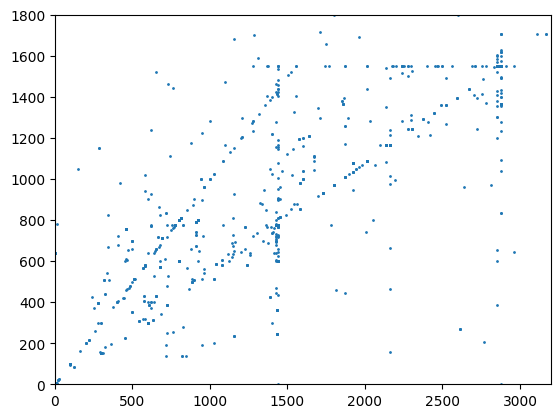

35

In [13]:
canvas_sizes = [y['canvasSize'] for x in gl_infos for y in x['contextInfo']]
# plot the distribution of canvas size( as scatter plot)
plt.scatter([x[0] for x in canvas_sizes], [x[1] for x in canvas_sizes], s=1)
plt.xlim(0, 3200)
plt.ylim(0, 1800)
plt.show()
# count the canvas which size is larger than 3200x1800
len([x for x in canvas_sizes if x[0] > 3200 or x[1] > 1800])

In [14]:
# fcontext_infos = [flatten_ctx_info(x) for x in context_infos]
fcontext_infos = []
fdf_columns = set()
for x in context_infos:
    fcontext_infos.append(flatten_ctx_info(x))
    fdf_columns.update(flatten_ctx_info(x).keys())

fdf = pd.DataFrame(fcontext_infos)
# fdf = pd.DataFrame(fcontext_infos, columns=sorted(fdf_columns))
fdf.to_pickle(OUT_PATH / 'df-hok-used-flatten.pkl.zstd', compression='zstd')
fdf = pd.read_pickle(OUT_PATH / 'df-hok-used-flatten.pkl.zstd', compression='zstd')
print(*fdf.columns.tolist(), sep='\n')
fdf.fillna(0, inplace=True)
fdf

url
when
accessTime
whenDomContentLoadedEvent
whenLoadEvent
whenUsedWebgl
contextType
rafCalled_total
rafCalled_max
program_count
program_use
shader_length
_memory_buffer
_memory_drawingbuffer
_memory_renderbuffer
_memory_texture
_memory_total
_resources_buffer
_resources_framebuffer
_resources_program
_resources_renderbuffer
_resources_shader
_resources_texture
total_func_call
total_memory
_func_call_attachShader
_func_call_bindBuffer
_func_call_bindTexture
_func_call_blendEquationSeparate
_func_call_blendFuncSeparate
_func_call_bufferData
_func_call_clear
_func_call_clearColor
_func_call_clearDepth
_func_call_clearStencil
_func_call_colorMask
_func_call_compileShader
_func_call_createBuffer
_func_call_createProgram
_func_call_createShader
_func_call_createTexture
_func_call_cullFace
_func_call_deleteShader
_func_call_depthFunc
_func_call_depthMask
_func_call_disable
_func_call_drawArrays
_func_call_enable
_func_call_enableVertexAttribArray
_func_call_frontFace
_func_call_getActiveAtt

,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,rafCalled_total,rafCalled_max,program_count,...,_func_call_getUniformIndices,_func_call_getRenderbufferParameter,_func_call_deleteQuery,_func_call_getTexParameter,_func_call_sampleCoverage,_func_call_stencilOpSeparate,_func_call_vertexAttrib4f,_func_call_getUniform,_func_call_stencilFuncSeparate,_func_call_isTexture
0,http://famoustache.com/dali,629259.6,1678093972061,8593.6,11540.6,8419.9,webgl,36674,36674,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://127.0.0.1:8000/test1/webgl/medium,43969.0,1678092972696,969.6,969.8,350.7,webgl2,187,187,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,http://127.0.0.1:8000/test1/webgl/hard,12215.5,1678092940405,1527.0,1527.3,408.7,webgl2,22,22,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://127.0.0.1:8000/test1/webgl/medium,11642.8,1678092940369,969.6,969.8,350.7,webgl2,42,42,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,http://127.0.0.1:8000/test3/webgl/medium,11309.4,1678092948059,718.4,718.5,547.4,webgl2,65,65,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7289,https://www.wearlively.com/collections/dd-ddd,12532.0,1678171398447,2947.9,3281.6,2419.4,webgl,929,885,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7290,https://www.wearlively.com/collections/dd-ddd,12532.0,1678171398447,2947.9,3281.6,2419.4,webgl,929,885,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7291,https://www.yourcpf.org/womens-health/,12510.9,1678171429329,2502.2,5897.1,2099.4,webgl,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7292,https://xebat.net/ku/,17942.7,1678171447301,7723.4,8729.3,7708.3,webgl,4,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
fdf.contextType.value_counts()

webgl                 6145
webgl2                 954
experimental-webgl     195
Name: contextType, dtype: int64

In [16]:
(fdf.when - fdf.whenUsedWebgl).describe()

count    7.294000e+03
mean     2.855317e+04
std      2.185585e+05
min      5.420000e+01
25%      1.015530e+04
50%      1.030860e+04
75%      1.046315e+04
max      3.544233e+06
dtype: float64

# `resources_texture`

AttributeError: 'DataFrame' object has no attribute 'resources_buffer'

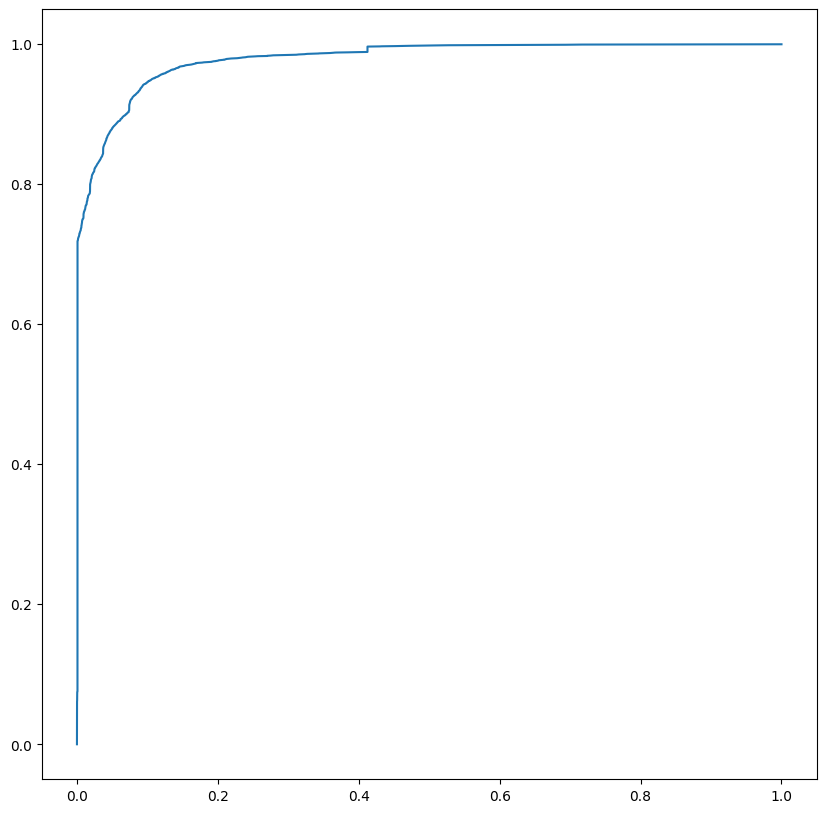

In [18]:
# fdf.resources_texture.plot()
# CDF
plt.figure(figsize=(10, 10))
plt.plot(np.sort(fdf.total_memory) / np.max(fdf.total_memory), np.linspace(0, 1, len(fdf.total_memory), endpoint=False), label='total_memory')
plt.plot(np.sort(fdf.resources_buffer) / np.max(fdf.resources_buffer), np.linspace(0, 1, len(fdf.resources_buffer), endpoint=False), label='resources_buffer')
plt.plot(np.sort(fdf.resources_framebuffer) / np.max(fdf.resources_framebuffer), np.linspace(0, 1, len(fdf.resources_framebuffer), endpoint=False), label='resources_framebuffer')
plt.plot(np.sort(fdf.resources_renderbuffer) / np.max(fdf.resources_renderbuffer), np.linspace(0, 1, len(fdf.resources_renderbuffer), endpoint=False), label='resources_renderbuffer')
plt.plot(np.sort(fdf.resources_shader) / np.max(fdf.resources_shader), np.linspace(0, 1, len(fdf.resources_shader), endpoint=False), label='resources_shader')
plt.plot(np.sort(fdf.resources_texture) / np.max(fdf.resources_texture), np.linspace(0, 1, len(fdf.resources_texture), endpoint=False), label='resources_texture')
plt.plot(np.sort(fdf.resources_program) / np.max(fdf.resources_program), np.linspace(0, 1, len(fdf.resources_program), endpoint=False), label='resources_program')
# axis name
plt.xlabel('texture')
plt.ylabel('CDF')
plt.legend()
# show
plt.show()

In [19]:
a_url_set = set(fdf[fdf.total_func_call==0].url)
b_url_set = set(fdf[fdf.total_func_call>0].url)
print(*sorted(a_url_set - b_url_set), sep='\n')

http://aifpa.net/
http://aifpa.net/current-notifications/
http://aifpa.net/newsletter/
http://aifpa.net/pjc-souvenir/
http://brienz-rothorn-bahn.ch/angebote/
http://deprogrammed.org/
http://dreamcityschools.org/
http://dreamcityschools.org/2205-2/
http://dreamcityschools.org/contact-us/
http://dreamcityschools.org/cte/
http://dreamcityschools.org/statement-of-faith/
http://dreamcityschools.org/uniform-2/
http://ferrovieappulolucane.it/
http://hollow.org.uk/
http://html-srv.com/game/gshell.html
http://imagesmagazinelr.com/
http://internationalbrandcreators.com/our-world/
http://ita.bsru.ac.th/
http://ita.bsru.ac.th/%e0%b8%a1%e0%b8%b2%e0%b8%95%e0%b8%a3%e0%b8%81%e0%b8%b2%e0%b8%a3%e0%b8%aa%e0%b9%88%e0%b8%87%e0%b9%80%e0%b8%aa%e0%b8%a3%e0%b8%b4%e0%b8%a1%e0%b8%84%e0%b8%b8%e0%b8%93%e0%b8%98%e0%b8%a3%e0%b8%a3%e0%b8%a1/
http://jatapartmani.com/
http://jatapartmani.com/typography/
http://jatapartmani.com/web_kamere/
http://mar-mot.pl/
http://marevivo.it/privacy-policy/
http://mippci.gob.ve/
http:

In [20]:
# corelation between `rafCalled, program_count, program_use, shader_length, memory_total, total_func_call`

from scipy.stats import spearmanr, linregress
import seaborn as sns

In [21]:
# df = fdf[['rafCalled_total', 'rafCalled_max', 'program_count', 'program_use', 'shader_length', 'memory_total', 'total_func_call']]

In [22]:
# spearman_corr = df.corr(method='spearman')
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(spearman_corr, annot=True, fmt='.3f', cmap='coolwarm', ax=ax, vmin=-1.0, vmax=1.0)
# plt.show()

In [23]:
# spearman_corr = fdf.corr(method='spearman', numeric_only=True)
# fig, ax = plt.subplots(figsize=(128, 128))
# sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax, vmin=-1, vmax=1)
# # plt.show()
# # save plot
# plt.savefig('spearman_corr.png', dpi=240)
# plt.close()

In [24]:
fdf[(fdf['total_memory'] == 0) & (fdf['total_func_call'] == 0) & (fdf['program_count'] == 0)]

,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,rafCalled_total,rafCalled_max,program_count,...,_func_call_getUniformIndices,_func_call_getRenderbufferParameter,_func_call_deleteQuery,_func_call_getTexParameter,_func_call_sampleCoverage,_func_call_stencilOpSeparate,_func_call_vertexAttrib4f,_func_call_getUniform,_func_call_stencilFuncSeparate,_func_call_isTexture


In [25]:
tmp = fdf[(fdf['total_func_call'] > 0)]
tmp

,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,rafCalled_total,rafCalled_max,program_count,...,_func_call_getUniformIndices,_func_call_getRenderbufferParameter,_func_call_deleteQuery,_func_call_getTexParameter,_func_call_sampleCoverage,_func_call_stencilOpSeparate,_func_call_vertexAttrib4f,_func_call_getUniform,_func_call_stencilFuncSeparate,_func_call_isTexture
0,http://famoustache.com/dali,629259.6,1678093972061,8593.6,11540.6,8419.9,webgl,36674,36674,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://127.0.0.1:8000/test1/webgl/medium,43969.0,1678092972696,969.6,969.8,350.7,webgl2,187,187,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,http://127.0.0.1:8000/test1/webgl/hard,12215.5,1678092940405,1527.0,1527.3,408.7,webgl2,22,22,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://127.0.0.1:8000/test1/webgl/medium,11642.8,1678092940369,969.6,969.8,350.7,webgl2,42,42,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,http://127.0.0.1:8000/test3/webgl/medium,11309.4,1678092948059,718.4,718.5,547.4,webgl2,65,65,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,https://www.magische-spiegelungen.de/,11620.0,1678160696481,1756.7,3435.4,1585.7,webgl2,450,297,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3606,https://www.soulaether.xyz/,11350.1,1678162754035,890.1,892.8,951.0,webgl2,489,239,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3607,https://www.kuajingvs.com/,12714.1,1678169621428,4319.8,12689.0,1448.7,webgl,254,254,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,https://www.kuajingvs.com/,12714.1,1678169621428,4319.8,12689.0,1448.7,webgl,254,254,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
tmp[tmp.total_memory < tmp.total_memory.max() / 100]

,url,when,accessTime,whenDomContentLoadedEvent,whenLoadEvent,whenUsedWebgl,contextType,rafCalled_total,rafCalled_max,program_count,...,_func_call_getUniformIndices,_func_call_getRenderbufferParameter,_func_call_deleteQuery,_func_call_getTexParameter,_func_call_sampleCoverage,_func_call_stencilOpSeparate,_func_call_vertexAttrib4f,_func_call_getUniform,_func_call_stencilFuncSeparate,_func_call_isTexture
6,http://koox.co.uk/,45157.3,1678093600025,1276.1,8467.3,4676.2,experimental-webgl,3697,1245,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,http://koox.co.uk/,15115.9,1678093569962,1276.1,8467.3,4676.2,experimental-webgl,994,344,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,http://vermenich.jazzprovince.ru/,44937.7,1678094045397,6239.8,12261.0,4688.8,webgl,1209,1209,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,https://www.ventiseidieci.it/,47514.1,1678094757507,7665.6,8367.6,7441.7,webgl,2411,1198,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,https://www.seaplane.io/,14845.6,1678162614262,4729.4,6129.4,4370.9,webgl2,2238,365,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,https://www.magische-spiegelungen.de/,11620.0,1678160696481,1756.7,3435.4,1585.7,webgl2,450,297,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3606,https://www.soulaether.xyz/,11350.1,1678162754035,890.1,892.8,951.0,webgl2,489,239,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3607,https://www.kuajingvs.com/,12714.1,1678169621428,4319.8,12689.0,1448.7,webgl,254,254,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,https://www.kuajingvs.com/,12714.1,1678169621428,4319.8,12689.0,1448.7,webgl,254,254,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


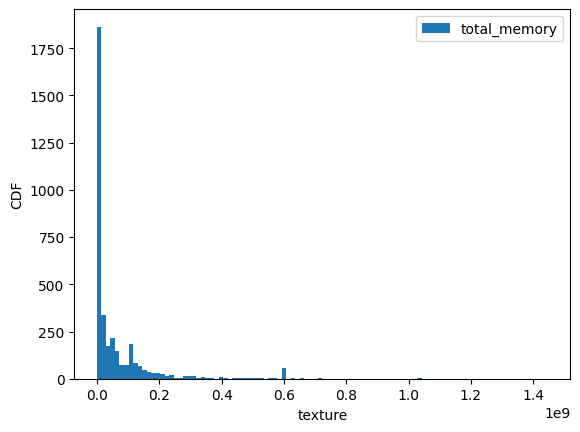

In [29]:
# tmp._resources_texture.plot()
# CDF
# plt.figure(figsize=(10, 10))
# plt.plot(np.sort(tmp.total_memory) / np.max(tmp.total_memory), np.linspace(0, 1, len(tmp.total_memory), endpoint=False), label='total_memory')
# plt.plot(np.sort(tmp._resources_buffer) / np.max(tmp._resources_buffer), np.linspace(0, 1, len(tmp._resources_buffer), endpoint=False), label='_resources_buffer')
# plt.plot(np.sort(tmp._resources_framebuffer) / np.max(tmp._resources_framebuffer), np.linspace(0, 1, len(tmp._resources_framebuffer), endpoint=False), label='_resources_framebuffer')
# plt.plot(np.sort(tmp._resources_renderbuffer) / np.max(tmp._resources_renderbuffer), np.linspace(0, 1, len(tmp._resources_renderbuffer), endpoint=False), label='_resources_renderbuffer')
# plt.plot(np.sort(tmp._resources_shader) / np.max(tmp._resources_shader), np.linspace(0, 1, len(tmp._resources_shader), endpoint=False), label='_resources_shader')
# plt.plot(np.sort(tmp._resources_texture) / np.max(tmp._resources_texture), np.linspace(0, 1, len(tmp._resources_texture), endpoint=False), label='_resources_texture')
# plt.plot(np.sort(tmp._resources_program) / np.max(tmp._resources_program), np.linspace(0, 1, len(tmp._resources_program), endpoint=False), label='_resources_program')
# axis name
# hist
plt.hist(tmp.total_memory, bins=100, label='total_memory')
plt.xlabel('texture')
plt.ylabel('CDF')
# plt.xscale('log')
plt.legend()
# show
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


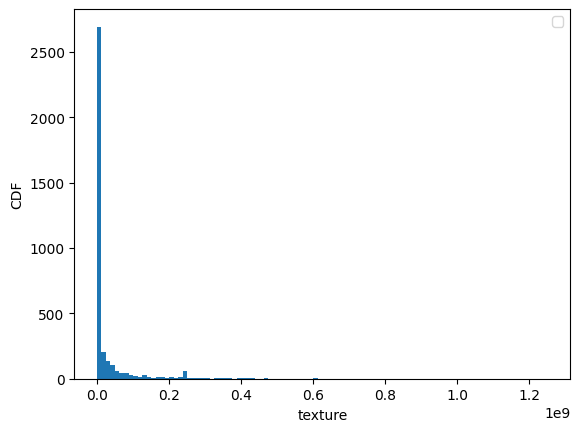

In [28]:
plt.hist(tmp._memory_texture, bins=100, label='_memory_texture')
plt.xlabel('texture')
plt.ylabel('CDF')
# plt.xscale('log')
plt.legend()
# show
plt.show()